In [1]:
#Upload Zip file and unzip it

#import zipfile as zf
#model_inputs = zf.ZipFile("model_inputs.zip", 'r')
#model_inputs.extractall('model_inputs')
#model_inputs.close()

#!pip install rasterio
#!pip install geopandas
#!pip install seaborn
#!pip install pandas
#!pip install rasterstats

#from rasterio.transform import from_origin
#from rasterstats import zonal_stats
#import seaborn as sns # similar to ggpot2 R library
#import matplotlib.pyplot as plt

In [2]:
import rasterio # similar to raster R library  
import geopandas as gpd #This includes fiona python library, and is similar to sp and sf R libraries
import pandas as pd

import numpy as np
from numpy import nan

from rasterio.plot import show

In [3]:
#geopandas built on top of fiona is used for reading and writing spacial data files 

#reading shp files using geopandas
mena_shp = gpd.read_file("model_inputs/model_inputs/MENA_countries_IWMI_final_buffer2.shp")	#read MENA_boundary shp file
mena_shp_buff = gpd.read_file("model_inputs/model_inputs/MENA_countries_IWMI_final_buffer2.shp")
mena_cnts = gpd.read_file("model_inputs/model_inputs/MENA_countries_IWMI_final2.shp")
#mena_shp.head()
#mena_shp.plot()

In [4]:
#reading input raster 
mena_zone_buff = rasterio.open("model_inputs/model_inputs/mena_zone_buff.tif")


mena_zone_buff_array = mena_zone_buff.read(1)  # Read the fist layer os raster data into a NumPy array 
mena_zone_buff_array[mena_zone_buff_array < 0] = np.nan 
mena_zone_buff_array[mena_zone_buff_array == 22] = np.nan



In [5]:
#terra and rgdal package in R overlaps with rasterio, gdal and geopandas python packages

mask = rasterio.open("model_inputs/model_inputs/mask_land_soutfall_river_new6.tif")
mena_zone = rasterio.open("model_inputs/model_inputs/mena_shp_rast_resamp.tif")
#coast_buff = rasterio.open("model_inputs/model_inputs/coastal_buff_10km_reclass.tif")
wbal = rasterio.open("model_inputs/model_inputs/wb_ltm_2015_resamp.tif") #precalculated file 
gwreach = rasterio.open("model_inputs/model_inputs/gw_reach_potential_2015_new_resamp.tif")

#There are 5 populations: ghspop, gpwpop, grump, lspop and wpop - change the below input for the required population accordingly 
gpwpop = rasterio.open("model_inputs/model_inputs/MENA_GPW_v4_pop_count_2015_1km_resamp.tif")  #read gpwpop data

ce = rasterio.open("model_inputs/model_inputs/TEXMHT_M_sl1-6avg_250m_ll_MENA_resampled_ce.tif")  #conveyance_efficiencey_based on soil texture


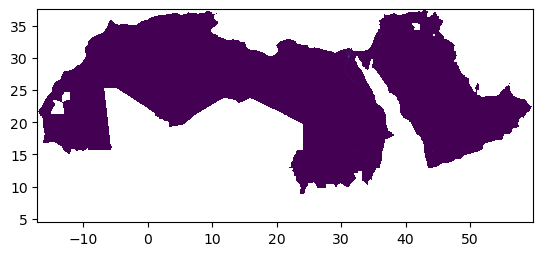

<Axes: >

In [6]:
####Visulaization of the relevant population data

data_gpwpop = gpwpop
show(data_gpwpop)

In [7]:
gpwpop_urclass = data_gpwpop.read() #Turns data_gpwpop raster into an array
# Set values below and equal 1 to NaN
gpwpop_urclass[gpwpop_urclass <= 1] = np.nan

# Set values between 1 and 300 (including 300) to 1
gpwpop_urclass[(gpwpop_urclass > 1) & (gpwpop_urclass <= 300)] = 1

# Set values between 300 and 1500 (including 1500) to 2
gpwpop_urclass[(gpwpop_urclass > 300) & (gpwpop_urclass <= 1500)] = 2

# Set values above 1500 to 3
gpwpop_urclass[gpwpop_urclass > 1500] = 3

print("\nReclassified Data:")
print(gpwpop_urclass)


Reclassified Data:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [8]:
#write the file
with rasterio.open('01_MENA_gpwpop_urban_rural_areas.tif', 'w',
                  driver = data_gpwpop.driver,
                  height = data_gpwpop.height,
                  width = data_gpwpop.width,
                  count = data_gpwpop.count,
                  crs = data_gpwpop.crs,
                  transform = data_gpwpop.transform, 
                  dtype = gpwpop_urclass.dtype
                   
                  ) as dst:
    dst.write(gpwpop_urclass)


In [9]:
###extract population counts for rural and urban classes  
####classifying class 3 as urban and class 1 & 2 as rural

rurpop = gpwpop.read()
rurpop[rurpop  < 0] = np.nan  
rurpop[(rurpop > 300)] = 0 # Set elements greater than 300 to 0


with rasterio.open('02_MENA_gpwpop_pop4rural_class_only.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = rurpop.dtype 
                  ) as dst:
    dst.write(rurpop)


In [10]:
urbpop = gpwpop.read()
urbpop[urbpop   < 0] = np.nan 
urbpop[(urbpop <= 300)] = 0 # Set elements less than or equal to 300 to 0


with rasterio.open('03_MENA_gpwpop_pop4urban_class_only.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urbpop.dtype
                   
                  ) as dst:
    dst.write(urbpop)

In [11]:
mena_zone_buff_flat = mena_zone_buff_array.flatten()
IDs = np.unique(mena_zone_buff_flat)  
IDs = IDs[~np.isnan(IDs)]
empty_1 = {'zone': [], 'sum': []}  #use a dictionary not a dataframe

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply transf with rurpop
    sum_zone = transf * rurpop
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_1['zone'].append(int(id))
    empty_1['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
ruralpop = pd.DataFrame(empty_1)

# Display the resulting DataFrame
print(ruralpop)


    zone            sum
0      1 32913197.25857
1      2 20642398.36719
2      3     7219.19852
3      4        0.00000
4      5 22747327.81459
5      6  1097560.78981
6      7  1522316.87445
7      8   854690.25758
8      9   898100.05801
9     10  5203128.92617
10    11 13706449.27440
11    12  2324102.29634
12    13   417910.69236
13    14 19228395.63628
14    15 12298900.04058
15    16  6583633.02818
16    17  2518376.84646
17    18   236109.97707
18    19 15951779.67103
19    20  4784474.42326
20    21  2563130.71574


In [12]:
empty_2 = {'zone': [], 'sum': []}  

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply transf with urbpop
    sum_zone = transf * urbpop
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_2['zone'].append(int(id))
    empty_2['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
urbanpop = pd.DataFrame(empty_2)

# Display the resulting DataFrame
print(urbanpop)


    zone            sum
0      1  4163925.52405
1      2 18079564.65112
2      3  1280907.53885
3      4   325033.25024
4      5 14999813.16168
5      6  5983630.17316
6      7  4654193.02545
7      8  1999808.70010
8      9  6080019.53210
9     10  1198555.70654
10    11 19760777.91498
11    12   736108.58725
12    13  2943143.59665
13    14 12555971.12485
14    15 11885111.95917
15    16  4623776.96924
16    17  4431148.09982
17    18  4987983.47263
18    19 10482048.85031
19    20 80852509.03830
20    21  1052182.13486


In [13]:
gpwpop_values = gpwpop.read()
gpwpop_values[gpwpop_values < 0] = np.nan

gpwtotpop = {'zone': [], 'sum': []}  

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply transf with gpwpop_values
    sum_zone = transf * gpwpop_values
    
    # Sum of values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    gpwtotpop['zone'].append(int(id))
    gpwtotpop['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
gpwtotal_pop = pd.DataFrame(gpwtotpop)

# Display the resulting DataFrame
print(gpwtotal_pop)  


    zone            sum
0      1 37077122.78262
1      2 38721963.01831
2      3  1288126.73736
3      4   325033.25024
4      5 37747140.97628
5      6  7081190.96297
6      7  6176509.89991
7      8  2854498.95768
8      9  6978119.59011
9     10  6401684.63271
10    11 33467227.18938
11    12  3060210.88359
12    13  3361054.28901
13    14 31784366.76113
14    15 24184011.99975
15    16 11207409.99742
16    17  6949524.94628
17    18  5224093.44970
18    19 26433828.52134
19    20 85636983.46156
20    21  3615312.85059


In [14]:
import pandas as pd

# Using the dataFrames named ruralpop, urbanpop, gpwtotal_pop, and mena_cnts

# Extracting columns 'sum' and 'id' from each DataFrame
rural_pop = ruralpop['sum']
urban_pop = urbanpop['sum']
gpwtot_pop = gpwtotal_pop['sum']

# Calculating total population
totpop = rural_pop + urban_pop

# Extracting columns 'MWW_new' and 'Tot_pop' from mena_cnts
mww = mena_cnts['MWW_new'] * 10**9
totalpop = mena_cnts['Tot_pop'] * 1000

# Handling NaN values in mww
mww = mww.fillna(0)

# Creating a DataFrame 'tot_pop'
tot_pop = pd.DataFrame({'totpop': totpop, 'rural_pop': rural_pop, 'urban_pop': urban_pop})

# Writing the DataFrame to a text file
tot_pop.to_csv('gpwpop_total_rural_urban_pop.txt', sep='\t', index=False) #, fmt='%.10f'


In [15]:
# Calculate per capita MWW

pc_mww = mww / totpop # pc_mww has 21 elements

In [16]:
# Write per capita MWW to a text file
pc_mww.to_csv('MENA_gpwpop_per_capita_mww.txt', header=False, index=False)

# Initialize empty vectors for pc_urban and pc_rural
pc_urban = np.empty(len(pc_mww))  
pc_rural = np.empty(len(pc_mww))

# Loop through each element in pc_mww
for i in range(len(pc_mww)): # has 21 elements
    pc_urb = pc_mww[i]
    urb_frac = 1.0

    while urb_frac <= 2.0:
        pc_rur = (mww[i] - (pc_urb * urban_pop[i])) / rural_pop[i]
        urb_frac = pc_urb / pc_rur
        pc_urb += 0.01

        if np.isnan(urb_frac):
            urb_frac = 2.1

    print(i)
    pc_urban[i] = pc_urb - 0.01
    pc_rural[i] = pc_rur

# Set the display format for floats
pd.options.display.float_format = '{:.12f}'.format

# Write pc_urban to a text file
np.savetxt('MENA_gpwpop_per_capita_mww_urban.txt', pc_urban, fmt='%.12f')

# Write pc_rural to a text file
np.savetxt('MENA_gpwpop_per_capita_mww_rural.txt', pc_rural, fmt='%.12f')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


C:\Users\i.wijayarathne\AppData\Local\Temp\ipykernel_884\1630044673.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pc_rur = (mww[i] - (pc_urb * urban_pop[i])) / rural_pop[i]


20


In [17]:
#computing a raster with pc_urban, use mena_zone_buff_array and multipy pc_urban values for each country.

mena_pc_urb = np.copy(mena_zone_buff_array)

#The loop for i in range(1, 22): iterates over the values from 1 to 21.
for i in range(1, 22):
    mena_pc_urb[mena_zone_buff_array == i] = pc_urban[i - 1]

mena_pc_rur = np.copy(mena_zone_buff_array)
for i in range(1, 22):
    mena_pc_rur[mena_zone_buff_array == i] = pc_rural[i - 1]
    
#mena_pc_urb and mena_pc_rur are numpy arrays

In [18]:
#computing rural MWW
rural_mww = rurpop * mena_pc_rur
rur = rasterio.open("02_MENA_gpwpop_pop4rural_class_only.tif")


with rasterio.open('004_MENA_gpwpop_mww_rural.tif', 'w',
                  driver = rur.driver,
                  height = rur.height,
                  width = rur.width,
                  count = rur.count,
                  crs = rur.crs,
                  transform = rur.transform, 
                  dtype = rural_mww.dtype
                   
                  ) as dst:
    dst.write(rural_mww)


In [19]:

urban_mww = urbpop * mena_pc_urb
urb = rasterio.open("03_MENA_gpwpop_pop4urban_class_only.tif")


with rasterio.open('005_MENA_gpwpop_mww_urban.tif', 'w',
                  driver = urb.driver,
                  height = urb.height,
                  width = urb.width,
                  count = urb.count,
                  crs = urb.crs,
                  transform = urb.transform, 
                  dtype = urban_mww.dtype
                   
                  ) as dst:
    dst.write(urban_mww)


In [20]:

gpwpop_mww = urban_mww + rural_mww


with rasterio.open('006_MENA_gpwpop_mww_total.tif', 'w',
                  driver = urb.driver,
                  height = urb.height,
                  width = urb.width,
                  count = urb.count,
                  crs = urb.crs,
                  transform = urb.transform, 
                  dtype = gpwpop_mww.dtype
                   
                  ) as dst:
    dst.write(gpwpop_mww)


In [21]:
empty_3 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf with rural_mww
    sum_zone = transf * rural_mww
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_3['zone'].append(int(id))
    empty_3['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.0f}'.format

# Convert the dictionary to a DataFrame
rural_mww_cnt = pd.DataFrame(empty_3)

print(rural_mww_cnt)

# Write to text file with specified format
np.savetxt('001_MENA_gpwpop_mww_rur_cnt.txt', rural_mww_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')


    zone        sum
0      1 1085346278
1      2  872090069
2      3     433176
3      4          0
4      5  469962349
5      6   44095220
6      7   23887966
7      8   54563446
8      9   31599772
9     10  328598123
10    11  182687910
11    12  140799671
12    13   13242416
13    14  693845416
14    15  402326613
15    16   99786723
16    17  165925743
17    18    3617182
18    19  125213901
19    20  186083155
20    21   65894534


In [22]:
empty_4 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf with urban_mww
    sum_zone = transf * urban_mww
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_4['zone'].append(int(id))
    empty_4['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.0f}'.format

# Convert the dictionary to a DataFrame
urban_mww_cnt = pd.DataFrame(empty_4)

print(urban_mww_cnt)
 
# Write to text file with specified format
np.savetxt('002_MENA_gpwpop_mww_urb_cnt.txt', urban_mww_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone        sum
0      1  274653763
1      2 1527909978
2      3  154566827
3      4   21609999
4      5  620037691
5      6  480904784
6      7  146112036
7      8  255436548
8      9  428400211
9     10  151401878
10    11  527312089
11    12   89200330
12    13  186757586
13    14  906154547
14    15  777673347
15    16  140213280
16    17  584074285
17    18  154772821
18    19  164786098
19    20 6313917095
20    21   54105467


In [23]:
empty_5 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf with gpwpop_mww
    sum_zone = transf * gpwpop_mww
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_5['zone'].append(int(id))
    empty_5['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
gpwpop_mww_cnt = pd.DataFrame(empty_5)

print(gpwpop_mww_cnt)

# Write to text file with specified format
np.savetxt('003_MENA_gpwpop_mww_tot_cnt.txt', gpwpop_mww_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone        sum
0      1 1360000041
1      2 2400000047
2      3  155000003
3      4          0
4      5 1090000040
5      6  525000004
6      7  170000002
7      8  309999994
8      9  459999983
9     10  480000001
10    11  709999998
11    12  230000001
12    13  200000002
13    14 1599999963
14    15 1179999960
15    16  240000003
16    17  750000028
17    18  158390003
18    19  289999998
19    20 6500000250
20    21  120000001


In [24]:
#model gw recharge fraction image

mww_m3 = gpwpop_mww
mww_mm = (mww_m3 / (833.33 * 833.33)) * 1000
wbal = rasterio.open("model_inputs/model_inputs/wb_ltm_2015_resamp.tif") #precalculated file copy this into the working directory
gwreach = rasterio.open("model_inputs/model_inputs/gw_reach_potential_2015_new_resamp.tif")

gwreach = gwreach.read()
gwreach[gwreach == np.min(gwreach)] = np.nan  # found using np.min(gwreach)
wbal_p = wbal.read()
wbal_p[wbal_p == np.min(wbal_p)] = np.nan
#wbal_p[wbal_p < 0] = 0 #converting all negative numbers to 0   
#compute gw recharge fraction


In [25]:
theta = (gwreach / (wbal_p + mww_mm))
theta[theta > 1] = 1
#set higher theta for negative wb pixels/irrigated areas
theta[wbal_p < 0] = 0.15  # assuming that MWW will recharge at a higher rates in the irrigated regions

In [26]:
#set theta for urban areas to 0.01
theta[gpwpop_values > 300] = 0.05 #set theta for urban clusters to 5%
theta[gpwpop_values > 1500] = 0.10 #set theta for urban to 10% (see references in the manuscript)
theta[np.isnan(theta)] = 0.1
theta[np.isnan(gpwpop_values)] = np.nan
theta[theta == 999] = 0.1

with rasterio.open('022_MENA_ghspop_groundwater_recharge_frac.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = theta.dtype
                   
                  ) as dst:
    dst.write(theta)


In [28]:
# Assuming mask is a NumPy array
riv_mask = mask.read()
riv_mask[riv_mask != 1] = np.nan

In [29]:
# Create a boolean mask where nan values are False and other values are True
bool_mask_1 = ~np.isnan(riv_mask)

# Apply the boolean mask to get the desired result
riv_mask_boolean = bool_mask_1.astype(bool)

# Display the original and boolean masked arrays
print("Original riv_mask:")
print(riv_mask)
print("\nBoolean Mask riv_mask_boolean:")
print(riv_mask_boolean)

Original riv_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask riv_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


In [30]:
# Create a new array with nan for False values in riv_mask
rural_mww_riv = np.where(riv_mask_boolean, rural_mww, np.nan)

# Display the result
print("Original rural_mww:", rural_mww)
print("rural_mww_riv:", rural_mww_riv)


Original rural_mww: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
rural_mww_riv: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [31]:
with rasterio.open('004_MENA_gpwpop_mww_rur_river.tif', 'w',
                  driver = mask.driver,
                  height = mask.height,
                  width = mask.width,
                  count = mask.count,
                  crs = mask.crs,
                  transform = mask.transform, 
                  dtype = rural_mww_riv.dtype
                   
                  ) as dst:
    dst.write(rural_mww_riv)
    
    
empty_6 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with rural_mww_riv
    sum_zone = transf * rural_mww_riv
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_6['zone'].append(int(id))
    empty_6['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
rural_mww_riv_cnt = pd.DataFrame(empty_6)

print(rural_mww_riv_cnt)

# Write to text file with specified format
np.savetxt('004_MENA_gpwpop_mww_rur_river_cnt.txt', rural_mww_riv_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone       sum
0      1 302989382
1      2 248604368
2      3         0
3      4         0
4      5 179947465
5      6   8182283
6      7  10073199
7      8  24969792
8      9         0
9     10  70777568
10    11  44740887
11    12   8176257
12    13       292
13    14 163225035
14    15 115652998
15    16  23213294
16    17  19727467
17    18   1913511
18    19  20381703
19    20  86444729
20    21  16683870


In [32]:
##extract Soutfall MWW (rural)
sout_mask = mask.read()
sout_mask[sout_mask != 2] = np.nan

# Create a boolean mask where nan values are False and other values are True
bool_mask_2 = ~np.isnan(sout_mask)

# Apply the boolean mask to get the desired result
sout_mask_boolean = bool_mask_2.astype(bool)

# Display the original and boolean masked arrays
print("Original sout_mask:")
print(sout_mask)
print("\nBoolean Mask sout_mask_boolean:")
print(sout_mask_boolean)

# Create a new array with nan for False values in sout_mask
rural_mww_soutfall = np.where(sout_mask_boolean, rural_mww, np.nan)

# Display the result
print("rural_mww_soutfall:", rural_mww_soutfall)


Original sout_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask sout_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
rural_mww_soutfall: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [33]:
with rasterio.open('005_MENA_gpwpop_mww_rur_seaoutfall.tif', 'w',
                  driver = mask.driver,
                  height = mask.height,
                  width = mask.width,
                  count = mask.count,
                  crs = mask.crs,
                  transform = mask.transform, 
                  dtype = rural_mww_soutfall.dtype
                   
                  ) as dst:
    dst.write(rural_mww_soutfall)
    
    
empty_7 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with rural_mww_soutfall
    sum_zone = transf * rural_mww_soutfall
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_7['zone'].append(int(id))
    empty_7['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
rural_mww_sout_cnt = pd.DataFrame(empty_7)

# Convert the column to integers
rural_mww_sout_cnt['zone'] = rural_mww_sout_cnt['zone'].astype(int)

print(rural_mww_sout_cnt)

np.savetxt('005_MENA_gpwpop_mww_rur_soutfall_cnt.txt', rural_mww_sout_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone      sum
0      1  3214609
1      2 57158224
2      3   433176
3      4        0
4      5 78414274
5      6  5855473
6      7   250741
7      8 10553588
8      9  5542691
9     10 27262481
10    11 17942614
11    12 27358438
12    13  7754253
13    14 36014146
14    15  7845405
15    16 17560799
16    17 27467151
17    18        0
18    19  5064657
19    20 31539783
20    21  4919643


In [34]:
##extract MWW land (rural)
oland_mask = mask.read()
oland_mask[oland_mask != 3] = np.nan

# Create a boolean mask where nan values are False and other values are True
bool_mask_3 = ~np.isnan(oland_mask)

# Apply the boolean mask to get the desired result
oland_mask_boolean = bool_mask_3.astype(bool)

# Display the original and boolean masked arrays
print("Original oland_mask:")
print(oland_mask)
print("\nBoolean Mask oland_mask_boolean:")
print(oland_mask_boolean)

# Create a new array with nan for False values in sout_mask
rural_mww_oland  = np.where(oland_mask_boolean, rural_mww, np.nan)

# Display the result
print("rural_mww_oland :", rural_mww_oland)


Original oland_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask oland_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
rural_mww_oland : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [35]:
with rasterio.open('006_MENA_gpwpop_mww_rur_oland.tif', 'w',
                  driver = mask.driver,
                  height = mask.height,
                  width = mask.width,
                  count = mask.count,
                  crs = mask.crs,
                  transform = mask.transform, 
                  dtype = rural_mww_oland.dtype
                   
                  ) as dst:
    dst.write(rural_mww_oland)
    
    
empty_8 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with rural_mww_oland
    sum_zone = transf * rural_mww_oland
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_8['zone'].append(int(id))
    empty_8['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
rural_mww_oland_cnt = pd.DataFrame(empty_8)

# Convert the column to integers
rural_mww_oland_cnt['zone'] = rural_mww_oland_cnt['zone'].astype(int)

print(rural_mww_oland_cnt)

np.savetxt('006_MENA_gpwpop_mww_rur_overland_cnt.txt', rural_mww_oland_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')


    zone       sum
0      1 779141780
1      2 566327477
2      3         0
3      4         0
4      5 211600610
5      6  30057464
6      7  13564026
7      8  19040066
8      9  26057080
9     10 230558074
10    11 120004409
11    12 105264976
12    13   5487871
13    14 494606235
14    15 278828210
15    16  59012630
16    17 118731124
17    18   1703671
18    19  99767541
19    20  68098643
20    21  44291021


In [36]:
##Extract MWW river (urban)

# Create a boolean mask where nan values are False and other values are True
bool_mask_4 = ~np.isnan(riv_mask)

# Apply the boolean mask to get the desired result
riv_mask_boolean = bool_mask_4.astype(bool)

# Display the original and boolean masked arrays
print("Original riv_mask:")
print(riv_mask)
print("\nBoolean Mask riv_mask_boolean:")
print(riv_mask_boolean)

# Create a new array with nan for False values in riv_mask
urban_mww_riv  = np.where(riv_mask_boolean, urban_mww, np.nan)

# Display the result
print("urban_mww_riv :", urban_mww_riv)



Original riv_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask riv_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
urban_mww_riv : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [37]:
with rasterio.open('007_MENA_gpwpop_mww_urb_river.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_mww_riv.dtype
                   
                  ) as dst:
    dst.write(urban_mww_riv)
    
    
empty_9 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with urban_mww_riv
    sum_zone = transf * urban_mww_riv
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_9['zone'].append(int(id))
    empty_9['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
urban_mww_riv_cnt = pd.DataFrame(empty_9)

# Convert the column to integers
urban_mww_riv_cnt['zone'] = urban_mww_riv_cnt['zone'].astype(int)

print(urban_mww_riv_cnt)

np.savetxt('007_MENA_gpwpop_mww_urb_river_cnt.txt', urban_mww_riv_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')


    zone        sum
0      1  148226257
1      2  344093606
2      3          0
3      4          0
4      5  405375400
5      6   22952773
6      7   20028104
7      8   35591148
8      9          0
9     10          0
10    11   93033709
11    12          0
12    13          0
13    14  146565676
14    15  151828595
15    16    5878283
16    17          0
17    18   35388253
18    19    4798014
19    20 5821330566
20    21     547931


In [38]:
##extract Soutfall MWW (urban)

# Create a new array with nan for False values in riv_mask
urban_mww_soutfall  = np.where(sout_mask_boolean, urban_mww, np.nan)

# Display the result
print("urban_mww_soutfall :", urban_mww_soutfall)

urban_mww_soutfall : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [39]:
with rasterio.open('008_MENA_gpwpop_mww_urb_seaoutfall.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_mww_soutfall.dtype
                   
                  ) as dst:
    dst.write(urban_mww_soutfall)
    
    
empty_10 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with urban_mww_soutfall
    sum_zone = transf * urban_mww_soutfall
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_10['zone'].append(int(id))
    empty_10['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
urban_mww_sout_cnt = pd.DataFrame(empty_10)

# Convert the column to integers
urban_mww_sout_cnt['zone'] = urban_mww_sout_cnt['zone'].astype(int)

print(urban_mww_sout_cnt)

np.savetxt('008_MENA_gpwpop_mww_urb_soutfall_cnt.txt', urban_mww_sout_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone       sum
0      1  30827466
1      2 602091659
2      3 136793961
3      4  21609999
4      5  25989938
5      6 345305570
6      7         0
7      8 219845401
8      9 332621764
9     10  86920533
10    11 252354632
11    12  56289333
12    13 133618206
13    14 289829129
14    15  62340228
15    16  92397780
16    17 110334104
17    18    693198
18    19  21389497
19    20 155429454
20    21  52366023


In [40]:
##extract MWW land (urban)

# Create a new array with nan for False values in riv_mask
urban_mww_oland  = np.where(oland_mask_boolean, urban_mww, np.nan)

# Display the result
print("urban_mww_oland :", urban_mww_oland)

urban_mww_oland : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [41]:
with rasterio.open('009_MENA_gpwpop_mww_urb_oland.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_mww_oland.dtype
                   
                  ) as dst:
    dst.write(urban_mww_oland)
    
    
empty_11 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with urban_mww_oland
    sum_zone = transf * urban_mww_oland
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_11['zone'].append(int(id))
    empty_11['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
urban_mww_oland_cnt  = pd.DataFrame(empty_11)

# Convert the column to integers
urban_mww_oland_cnt['zone'] = urban_mww_oland_cnt['zone'].astype(int)

print(urban_mww_oland_cnt)

np.savetxt('009_MENA_gpwpop_mww_urb_overland_cnt.txt', urban_mww_oland_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone       sum
0      1  95600039
1      2 581724713
2      3  17772866
3      4         0
4      5 188672352
5      6 112646441
6      7 126083932
7      8         0
8      9  95778447
9     10  64481345
10    11 181923748
11    12  32910996
12    13  53139380
13    14 469759741
14    15 563504524
15    16  41937217
16    17 473740181
17    18 118691370
18    19 138598587
19    20 337157075
20    21   1191512


In [43]:
file_path = "model_inputs/model_inputs/direct_reuse_new2.txt"

# Read the text file into a DataFrame
dir_reuse = pd.read_csv(file_path, sep='\t')

# Display the DataFrame
print(dir_reuse)

    No      Country  river  coast  land  total
0    1        Sudan     29      0     0     29
1    2      Algeria     56      8    36    100
2    3      Bahrain      0     30     0     30
3    4        Gaza       0      0     0      0
4    5         Iraq      0      0     0      0
5    6       Israel      0      0     0      0
6    7       Jordan      6      0    65     71
7    8       Kuwait     10    259     0    268
8    9      Lebanon      0      0     2      2
9   10       Libyan      0     40     0     40
10  11      Morocco      3     26    47     76
11  12         Oman      0     64     5     70
12  13        Qatar      0    136     0    136
13  14  SaudiArabia      4    200   188    392
14  15        Syria      0      0     0      0
15  16      Tunisia      6     27     1     34
16  17          UAE      1    406   116    540
17  18     WestBank      0      0     6      6
18  19        Yemen      0     12    24     36
19  20        Egypt    111     44   134    289
20  21   Maur

In [44]:
theta_array = theta.astype(float)  # Convert to float data type

empty_12 = {'zone': [], 'mean': []}

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with theta_array
    sum_zone = transf * theta_array
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Number of values corresponding to the current ID
    num_values = np.sum(transf)
    
    # Calculate the mean by dividing the sum by the number of values
    mean_zone = sum_zone / num_values if num_values != 0 else np.nan
    
    # Append the calculated mean for the current id to the dictionary
    empty_12['zone'].append(int(id))
    empty_12['mean'].append(float(mean_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
theta_cnt = pd.DataFrame(empty_12)

# Convert the column to integers
theta_cnt['zone'] = theta_cnt['zone'].astype(int)

print(theta_cnt)


    zone    mean
0      1 0.07137
1      2 0.06933
2      3 0.02717
3      4 0.02776
4      5 0.04631
5      6 0.04254
6      7 0.03485
7      8 0.03736
8      9 0.11502
9     10 0.02731
10    11 0.17710
11    12 0.06361
12    13 0.01878
13    14 0.02715
14    15 0.05487
15    16 0.08122
16    17 0.02514
17    18 0.06669
18    19 0.04110
19    20 0.02341
20    21 0.05241


In [45]:
ce_array = ce.read()
ce_array = ce_array.astype(float)  # Convert to float data type

ce_array[ce_array < 0] = np.nan  # Assign NaN to where it is required


empty_13 = {'zone': [], 'mean': []}

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with ce_array
    sum_zone = transf * ce_array
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Number of values corresponding to the current ID
    num_values = np.sum(transf)
    
    # Calculate the mean by dividing the sum by the number of values
    mean_zone = sum_zone / num_values if num_values != 0 else np.nan
    
    # Append the calculated mean for the current id to the dictionary
    empty_13['zone'].append(int(id))
    empty_13['mean'].append(float(mean_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
ce_cnt = pd.DataFrame(empty_13)

# Convert the column to integers
ce_cnt['zone'] = ce_cnt['zone'].astype(int)

print(ce_cnt)

    zone     mean
0      1 64.92128
1      2 63.38286
2      3 23.34352
3      4 21.45741
4      5 65.97221
5      6 65.34341
6      7 68.09275
7      8 59.86747
8      9 62.89358
9     10 61.83572
10    11 66.85064
11    12 61.21406
12    13 52.34362
13    14 62.84147
14    15 67.39905
15    16 64.45756
16    17 56.87946
17    18 67.32263
18    19 61.95166
19    20 61.40308
20    21 61.85848


In [46]:
ce_cnt_val = ce_cnt['mean']	
ce_cnt_val = ce_cnt_val.copy()  # Create a copy of the DataFrame
ce_cnt_val[ce_cnt_val > 100] = 100

In [47]:
mww_riv_cnt = rural_mww_riv_cnt['sum'] + urban_mww_riv_cnt['sum']
mww_riv_dru = dir_reuse['river'] * 10**6

In [48]:
mww_riv_gwr = (mww_riv_cnt - mww_riv_dru) * theta_cnt['mean']  # groundwater recharge (indirect reuse part)
mww_riv_rir = (mww_riv_cnt - mww_riv_dru - mww_riv_gwr) * (ce_cnt_val/100)  #river indirect reuse		
mww_riv_pir = mww_riv_gwr + mww_riv_rir	#total productive use (indirect)
mww_riv_upu = mww_riv_cnt - mww_riv_dru - mww_riv_pir 	#unproductive use
mww_riv_pu = mww_riv_pir + mww_riv_dru	#total productive use (direct + indirect)

In [49]:
mww_sea_cnt = rural_mww_sout_cnt['sum'] + urban_mww_sout_cnt['sum']
mww_sea_dru = dir_reuse['coast'] * 10**6
mww_sea_pir = (mww_sea_cnt - mww_sea_dru) * theta_cnt['mean']
mww_sea_upu = mww_sea_cnt - mww_sea_dru - mww_sea_pir
mww_sea_pu = mww_sea_pir + mww_sea_dru

mww_land_cnt = rural_mww_oland_cnt['sum'] + urban_mww_oland_cnt['sum']
mww_land_dru = dir_reuse['land'] * 10**6
mww_land_pir = (mww_land_cnt - mww_land_dru) * theta_cnt['mean']
mww_land_upu = mww_land_cnt - mww_land_dru - mww_land_pir
mww_land_pu = mww_land_pir + mww_land_dru

In [50]:
cnt_list = mena_cnts['ADM0_NAME']

# Create a DataFrame
data_out_riv = pd.DataFrame({
    'cnt_list': cnt_list,
    'mww_riv_dru': mww_riv_dru,
    'mww_sea_dru': mww_sea_dru,
    'mww_land_dru': mww_land_dru,
    'mww_riv_pir': mww_riv_pir,
    'mww_sea_pir': mww_sea_pir,
    'mww_land_pir': mww_land_pir,
    'mww_riv_upu': mww_riv_upu,
    'mww_sea_upu': mww_sea_upu,
    'mww_land_upu': mww_land_upu
})

data_out_riv.iloc[:, 1:10] = data_out_riv.iloc[:, 1:10] / 10**6


In [51]:
# Save the values to a text file.
header_str = '\t'.join(data_out_riv.columns)
np.savetxt('023_MENA_ghspop_mww_table3.txt', data_out_riv.values, fmt=['%s'] + ['%.6f'] * (data_out_riv.shape[1] - 1), header=header_str, delimiter='\t', comments='')

In [52]:
##Estimate prod and unprod from river (rural)
rural_mww_riv_pgwr = rural_mww_riv * theta
rural_mww_riv_pir = (0.6 * (rural_mww_riv - rural_mww_riv_pgwr)) + rural_mww_riv_pgwr
#rural_mww_riv_prod1 = rural_mww_riv * theta
#rural_mww_riv_prod2 = (rural_mww_riv - rural_mww_riv_prod1) * (0.6) #here conv eff = 0.6 and application eff = 0.6 (FAO, 1989)
#rural_mww_riv_prod = rural_mww_riv_prod1 + rural_mww_riv_prod2
rural_mww_riv_unprod = rural_mww_riv - rural_mww_riv_pir
rural_mww_riv_prod = rural_mww_riv - rural_mww_riv_unprod

In [53]:
rural_mww_riv_unprod = rural_mww_riv_unprod.astype(float)  # Convert to float data type

rural_mww_riv_unprod[rural_mww_riv_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_14 = {'zone': [], 'sum': []}

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_riv_unprod
    sum_zone = transf * rural_mww_riv_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_14['zone'].append(int(id))
    empty_14['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_riv_unprod_cnt = pd.DataFrame(empty_14)

# Convert the column to integers
rural_mww_riv_unprod_cnt['zone'] = rural_mww_riv_unprod_cnt['zone'].astype(int)

print(rural_mww_riv_unprod_cnt)


    zone          sum
0      1 108130295.75
1      2  87729686.79
2      3         0.00
3      4         0.00
4      5  65007844.80
5      6   3017919.71
6      7   3683953.31
7      8   9815352.64
8      9         0.00
9     10  27245722.64
10    11  14931749.71
11    12   2922632.74
12    13       116.86
13    14  61837874.08
14    15  41481537.53
15    16   8344954.27
16    17   7784195.84
17    18    662734.29
18    19   6644238.63
19    20  30817672.32
20    21   5768788.55


In [54]:
rural_mww_riv_unprod = rural_mww_riv_unprod.astype(float)  # Convert to float data type

rural_mww_riv_unprod[rural_mww_riv_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_14 = {'zone': [], 'sum': []}

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_riv_unprod
    sum_zone = transf * rural_mww_riv_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_14['zone'].append(int(id))
    empty_14['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_riv_unprod_cnt = pd.DataFrame(empty_14)

# Convert the column to integers
rural_mww_riv_unprod_cnt['zone'] = rural_mww_riv_unprod_cnt['zone'].astype(int)

print(rural_mww_riv_unprod_cnt)

    zone          sum
0      1 108130295.75
1      2  87729686.79
2      3         0.00
3      4         0.00
4      5  65007844.80
5      6   3017919.71
6      7   3683953.31
7      8   9815352.64
8      9         0.00
9     10  27245722.64
10    11  14931749.71
11    12   2922632.74
12    13       116.86
13    14  61837874.08
14    15  41481537.53
15    16   8344954.27
16    17   7784195.84
17    18    662734.29
18    19   6644238.63
19    20  30817672.32
20    21   5768788.55


In [55]:
rural_mww_riv_prod = rural_mww_riv_prod.astype(float)  # Convert to float data type

rural_mww_riv_prod[rural_mww_riv_prod < 0] = np.nan  # Assign NaN to where it is required

empty_15 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_riv_prod
    sum_zone = transf * rural_mww_riv_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_15['zone'].append(int(id))
    empty_15['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_riv_prod_cnt = pd.DataFrame(empty_15)  # Change 'empty_14' to 'empty_15'

# Convert the column to integers
rural_mww_riv_prod_cnt['zone'] = rural_mww_riv_prod_cnt['zone'].astype(int)

print(rural_mww_riv_prod_cnt)


    zone          sum
0      1 194859086.16
1      2 160874681.14
2      3         0.00
3      4         0.00
4      5 114939620.46
5      6   5164363.62
6      7   6389245.73
7      8  15154439.01
8      9         0.00
9     10  43531845.20
10    11  29809136.88
11    12   5253623.91
12    13       175.29
13    14 101387160.99
14    15  74171460.30
15    16  14868339.63
16    17  11943271.45
17    18   1250776.50
18    19  13737464.21
19    20  55627056.54
20    21  10915081.93


In [56]:
with rasterio.open('010_MENA_gpwpop_MWW_river_discharge_unprod_rural.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = rural_mww_riv_unprod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_riv_unprod)


np.savetxt('010_MENA_gpwpop_mww_rur_river_unprod_cnt.txt', rural_mww_riv_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [57]:
with rasterio.open('011_MENA_gpwpop_MWW_river_discharge_pot_reuse_rural.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = rural_mww_riv_prod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_riv_prod)


np.savetxt('0011_MENA_gpwpop_mww_rur_river_prod_cnt.txt', rural_mww_riv_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [58]:
##estimate prod and unprod from seaoutfall (rural)
rural_sout_prod = rural_mww_soutfall * theta
rural_sout_unprod = rural_mww_soutfall - rural_sout_prod


In [59]:
rural_sout_prod = rural_sout_prod.astype(float)  # Convert to float data type

rural_sout_prod[rural_sout_prod < 0] = np.nan  # Assign NaN to where it is required

empty_16 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_sout_prod
    sum_zone = transf * rural_sout_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_16['zone'].append(int(id))
    empty_16['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_sout_prod_cnt = pd.DataFrame(empty_16)  # Change 'empty_15' to 'empty_16'

# Convert the column to integers
rural_sout_prod_cnt['zone'] = rural_sout_prod_cnt['zone'].astype(int)

print(rural_sout_prod_cnt)

    zone        sum
0      1  447628.37
1      2 8592197.13
2      3   43317.60
3      4       0.00
4      5 7715210.80
5      6  872143.49
6      7   36716.10
7      8 2466679.14
8      9  806686.71
9     10 3660543.12
10    11 2484239.19
11    12 4450806.25
12    13  272150.48
13    14 3569156.79
14    15 1152354.12
15    16 2282589.64
16    17 2671786.69
17    18       0.00
18    19 1090236.13
19    20 5024365.24
20    21  631806.78


In [60]:
rural_sout_unprod = rural_sout_unprod.astype(float)  # Convert to float data type

rural_sout_unprod[rural_sout_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_17 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_sout_unprod
    sum_zone = transf * rural_sout_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_17['zone'].append(int(id))
    empty_17['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_sout_unprod_cnt = pd.DataFrame(empty_17)  # Change 'empty_16' to 'empty_17'

# Convert the column to integers
rural_sout_unprod_cnt['zone'] = rural_sout_unprod_cnt['zone'].astype(int)

print(rural_sout_unprod_cnt)


    zone         sum
0      1  2766980.27
1      2 48566026.88
2      3   389858.38
3      4        0.00
4      5 70699062.97
5      6  4983329.22
6      7   214024.54
7      8  8086909.23
8      9  4736004.78
9     10 23601937.47
10    11 15458374.83
11    12 22907632.25
12    13  7482102.69
13    14 32444989.59
14    15  6693051.25
15    16 15278209.54
16    17 24795364.72
17    18        0.00
18    19  3974420.42
19    20 26515417.68
20    21  4287836.20


In [61]:
with rasterio.open('012_MENA_gpwpop_mww_soutfall_prod_rur.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = rural_sout_prod.dtype
                   
                  ) as dst:
    dst.write(rural_sout_prod)


np.savetxt('012_MENA_gpwpop_mww_rur_soutfall_prod_cnt.txt', rural_sout_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [62]:
with rasterio.open('013_MENA_gpwpop_mww_soutfall_unprod_rur.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = rural_sout_unprod.dtype
                   
                  ) as dst:
    dst.write(rural_sout_unprod)


np.savetxt('013_MENA_gpwpop_mww_rur_soutfall_unprod_cnt.txt', rural_sout_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [63]:
##Estimate prod and unprod from oland (rural)
rural_mww_oland_prod = rural_mww_oland * theta
rural_mww_oland_unprod = rural_mww_oland - rural_mww_oland_prod

In [64]:
rural_mww_oland_prod = rural_mww_oland_prod.astype(float)  # Convert to float data type

rural_mww_oland_prod[rural_mww_oland_prod < 0] = np.nan  # Assign NaN to where it is required

empty_18 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_oland_prod
    sum_zone = transf * rural_mww_oland_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_18['zone'].append(int(id))
    empty_18['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_oland_prod_cnt = pd.DataFrame(empty_18)  # Change 'empty_17' to 'empty_18'

# Convert the column to integers
rural_mww_oland_prod_cnt['zone'] = rural_mww_oland_prod_cnt['zone'].astype(int)

print(rural_mww_oland_prod_cnt)


    zone         sum
0      1 65857922.26
1      2 58198368.72
2      3        0.00
3      4        0.00
4      5 20963299.54
5      6  2370679.29
6      7   587376.88
7      8  1172242.45
8      9  3995839.18
9     10 18543985.88
10    11 18202603.31
11    12 14789213.47
12    13     3474.80
13    14 40738684.28
14    15 32956815.40
15    16  5551481.03
16    17  3942069.03
17    18   167305.05
18    19 12395396.47
19    20  4431565.53
20    21  6152000.83


In [65]:
rural_mww_oland_unprod = rural_mww_oland_unprod.astype(float)  # Convert to float data type

rural_mww_oland_unprod[rural_mww_oland_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_19 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_oland_unprod
    sum_zone = transf * rural_mww_oland_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_19['zone'].append(int(id))
    empty_19['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_oland_unprod_cnt = pd.DataFrame(empty_19)  # Change 'empty_18' to 'empty_19'

# Convert the column to integers
rural_mww_oland_unprod_cnt['zone'] = rural_mww_oland_unprod_cnt['zone'].astype(int)

print(rural_mww_oland_unprod_cnt)


    zone          sum
0      1 713283857.86
1      2 508129107.99
2      3         0.00
3      4         0.00
4      5 190637310.38
5      6  27686784.54
6      7  12976649.58
7      8  17867823.18
8      9  22061241.00
9     10 212014088.62
10    11 101801805.63
11    12  90475762.70
12    13   5484395.82
13    14 453867550.39
14    15 245871394.59
15    16  53461148.83
16    17 114789055.03
17    18   1536366.40
18    19  87372144.64
19    20  63667077.94
20    21  38139019.94


In [66]:
with rasterio.open('014_MENA_gpwpop_mww_oland_prod_rur.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = rural_mww_oland_prod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_oland_prod)


np.savetxt('014_MENA_gpwpop_mww_rur_oland_prod_cnt.txt', rural_mww_oland_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [67]:
with rasterio.open('015_MENA_gpwpop_mww_oland_prod_rur.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = rural_mww_oland_unprod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_oland_unprod)


np.savetxt('015_MENA_gpwpop_mww_rur_oland_unprod_cnt.txt', rural_mww_oland_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [68]:
##Estimate prod and unprod from river (urban)
urban_mww_riv_pgwr = urban_mww_riv * theta
urban_mww_riv_pir = (0.6 * (urban_mww_riv - urban_mww_riv_pgwr)) + urban_mww_riv_pgwr
# urban_mww_riv_prod1 = urban_mww_riv * theta
# urban_mww_riv_prod2 = (urban_mww_riv - urban_mww_riv_prod1) * (0.6) #here conv eff = 0.6 (FAO, 1989)
# urban_mww_riv_prod = urban_mww_riv_prod1 + urban_mww_riv_prod2
# urban_mww_riv_unprod = urban_mww_riv - urban_mww_riv_prod
urban_mww_riv_unprod = urban_mww_riv - urban_mww_riv_pir
urban_mww_riv_prod = urban_mww_riv - urban_mww_riv_unprod

In [69]:
urban_mww_riv_unprod = urban_mww_riv_unprod.astype(float)  # Convert to float data type

urban_mww_riv_unprod[urban_mww_riv_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_20 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_riv_unprod
    sum_zone = transf * urban_mww_riv_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_20['zone'].append(int(id))
    empty_20['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_riv_unprod_cnt = pd.DataFrame(empty_20)  # Change 'empty_19' to 'empty_20'

# Convert the column to integers
urban_mww_riv_unprod_cnt['zone'] = urban_mww_riv_unprod_cnt['zone'].astype(int)

print(urban_mww_riv_unprod_cnt)


    zone           sum
0      1   55314862.88
1      2  129520683.86
2      3          0.00
3      4          0.00
4      5  148910876.43
5      6    8722053.14
6      7    7610679.22
7      8   12827224.22
8      9          0.00
9     10          0.00
10    11   33925019.32
11    12          0.00
12    13          0.00
13    14   55694953.69
14    15   57323468.30
15    16    2187408.12
16    17          0.00
17    18   13447535.23
18    19    1820553.74
19    20 2135273031.48
20    21     208213.94


In [70]:
urban_mww_riv_prod = urban_mww_riv_prod.astype(float)  # Convert to float data type

urban_mww_riv_prod[urban_mww_riv_prod < 0] = np.nan  # Assign NaN to where it is required

empty_21 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_riv_prod
    sum_zone = transf * urban_mww_riv_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_21['zone'].append(int(id))
    empty_21['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_riv_prod_cnt = pd.DataFrame(empty_21)  # Change 'empty_20' to 'empty_21'

# Convert the column to integers
urban_mww_riv_prod_cnt['zone'] = urban_mww_riv_prod_cnt['zone'].astype(int)

print(urban_mww_riv_prod_cnt)


    zone           sum
0      1   92911394.43
1      2  214572921.96
2      3          0.00
3      4          0.00
4      5  256464523.58
5      6   14230719.63
6      7   12417425.09
7      8   22763923.54
8      9          0.00
9     10          0.00
10    11   59108689.83
11    12          0.00
12    13          0.00
13    14   90870722.49
14    15   94505126.58
15    16    3690874.75
16    17          0.00
17    18   21940717.59
18    19    2977460.12
19    20 3686057534.48
20    21     339717.51


In [71]:
with rasterio.open('016_MENA_gpwpop_MWW_river_discharge_unprod_urban.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_mww_riv_unprod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_riv_unprod)


np.savetxt('016_MENA_gpwpop_mww_urban_river_unprod_cnt.txt', urban_mww_riv_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [72]:
with rasterio.open('017_MENA_gpwpop_MWW_river_discharge_pot_reuse_urban.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_mww_riv_prod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_riv_prod)


np.savetxt('017_MENA_gpwpop_mww_urbanriver_prod_cnt.txt', urban_mww_riv_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [73]:
##estimate prod and unprod from seaoutfall (urban)
urban_sout_prod = urban_mww_soutfall * theta
urban_sout_unprod = urban_mww_soutfall - urban_sout_prod

In [74]:
urban_sout_prod = urban_sout_prod.astype(float)  # Convert to float data type

urban_sout_prod[urban_sout_prod < 0] = np.nan  # Assign NaN to where it is required

empty_22 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_sout_prod
    sum_zone = transf * urban_sout_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_22['zone'].append(int(id))
    empty_22['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_sout_prod_cnt = pd.DataFrame(empty_22)  # Change 'empty_21' to 'empty_22'

# Convert the column to integers
urban_sout_prod_cnt['zone'] = urban_sout_prod_cnt['zone'].astype(int)

print(urban_sout_prod_cnt)

    zone         sum
0      1  1541373.35
1      2 51302222.78
2      3 13101200.37
3      4  2160999.98
4      5  1299496.94
5      6 29777983.96
6      7        0.00
7      8 21935885.76
8      9 29805133.82
9     10  4346026.70
10    11 23762737.56
11    12  2814466.72
12    13 11889048.91
13    14 14491456.67
14    15  4691771.47
15    16  6919641.28
16    17  5516705.26
17    18    57923.18
18    19  1785162.74
19    20 12253481.85
20    21  4970540.58


In [75]:
urban_sout_unprod = urban_sout_unprod.astype(float)  # Convert to float data type

urban_sout_unprod[urban_sout_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_23 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_sout_unprod
    sum_zone = transf * urban_sout_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_23['zone'].append(int(id))
    empty_23['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_sout_unprod_cnt = pd.DataFrame(empty_23)  # Change 'empty_22' to 'empty_23'

# Convert the column to integers
urban_sout_unprod_cnt['zone'] = urban_sout_unprod_cnt['zone'].astype(int)

print(urban_sout_unprod_cnt)

    zone          sum
0      1  29286093.19
1      2 550789436.77
2      3 123692760.82
3      4  19448999.57
4      5  24690441.44
5      6 315527586.35
6      7         0.00
7      8 197909515.28
8      9 302816631.29
9     10  82574505.96
10    11 228591894.52
11    12  53474866.79
12    13 121729156.87
13    14 275337672.55
14    15  57648456.69
15    16  85478138.96
16    17 104817398.53
17    18    635275.01
18    19  19604333.81
19    20 143175972.58
20    21  47395482.77


In [76]:
with rasterio.open('018_MENA_gpwpop_mww_soutfall_prod_urban.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_sout_prod.dtype
                   
                  ) as dst:
    dst.write(urban_sout_prod)


np.savetxt('018_MENA_gpwpop_mww_urban_soutfall_prod_cnt.txt', urban_sout_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [77]:
with rasterio.open('019_MENA_gpwpop_mww_soutfall_prod_urban.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_sout_unprod.dtype
                   
                  ) as dst:
    dst.write(urban_sout_unprod)


np.savetxt('019_MENA_gpwpop_mww_urban_soutfall_unprod_cnt.txt', urban_sout_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [78]:
##Estimate prod and unprod from oland (urban)
urban_mww_oland_prod = urban_mww_oland * theta
urban_mww_oland_unprod = urban_mww_oland - urban_mww_oland_prod

In [79]:
urban_mww_oland_prod = urban_mww_oland_prod.astype(float)  # Convert to float data type

urban_mww_oland_prod[urban_mww_oland_prod < 0] = np.nan  # Assign NaN to where it is required

empty_24 = {'zone': [], 'sum': []}  # Change 'empty_23' to 'empty_24'

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_oland_prod
    sum_zone = transf * urban_mww_oland_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_24['zone'].append(int(id))
    empty_24['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_oland_prod_cnt = pd.DataFrame(empty_24)  # Change 'empty_23' to 'empty_24'

# Convert the column to integers
urban_mww_oland_prod_cnt['zone'] = urban_mww_oland_prod_cnt['zone'].astype(int)

print(urban_mww_oland_prod_cnt)


    zone         sum
0      1  6728208.36
1      2 38532755.79
2      3  1381166.34
3      4        0.00
4      5 10485746.45
5      6  7487800.74
6      7  9886502.94
7      8        0.00
8      9  5903409.52
9     10  3224067.30
10    11 15998095.15
11    12  1645549.84
12    13  4321961.29
13    14 23487987.44
14    15 47354404.89
15    16  3325347.12
16    17 23687009.41
17    18  8071439.01
18    19  9685733.52
19    20 24110951.60
20    21    59575.61


In [80]:
urban_mww_oland_unprod = urban_mww_oland_unprod.astype(float)  # Convert to float data type

urban_mww_oland_unprod[urban_mww_oland_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_25 = {'zone': [], 'sum': []}  # Change 'empty_24' to 'empty_25'

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_oland_unprod
    sum_zone = transf * urban_mww_oland_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_25['zone'].append(int(id))
    empty_25['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_oland_unprod_cnt = pd.DataFrame(empty_25)  # Change 'empty_24' to 'empty_25'

# Convert the column to integers
urban_mww_oland_unprod_cnt['zone'] = urban_mww_oland_unprod_cnt['zone'].astype(int)

print(urban_mww_oland_unprod_cnt)


    zone          sum
0      1  88871830.83
1      2 543191957.65
2      3  16391700.03
3      4         0.00
4      5 178186606.04
5      6 105158640.52
6      7 116197429.26
7      8         0.00
8      9  89875038.12
9     10  61257277.44
10    11 165925653.05
11    12  31265446.61
12    13  48817419.11
13    14 446271753.99
14    15 516150119.40
15    16  38611869.94
16    17 450053173.10
17    18 110619930.95
18    19 128912854.14
19    20 313046124.22
20    21   1131936.67


In [81]:
with rasterio.open('020_MENA_gpwpop_mww_oland_prod_urban.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_mww_oland_prod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_oland_prod)


np.savetxt('020_MENA_gpwpop_mww_urban_river_prod_cnt.txt', urban_mww_oland_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [82]:
with rasterio.open('021_MENA_gpwpop_mww_oland_prod_urban.tif', 'w',
                  driver = gpwpop.driver,
                  height = gpwpop.height,
                  width = gpwpop.width,
                  count = gpwpop.count,
                  crs = gpwpop.crs,
                  transform = gpwpop.transform, 
                  dtype = urban_mww_oland_unprod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_oland_unprod)


np.savetxt('021_MENA_gpwpop_mww_urban_oland_unprod_cnt.txt', urban_mww_oland_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [83]:
####end of code
####end of code
####end of code
####end of code
####end of code
####end of code
####end of code####end of code####end####end of code
####end of code####end of code####end
